In [1]:
import pandas as pd 

### Reading and modifying 

In [2]:
dfc = pd.read_csv('1.csv')

In [3]:
dfr = pd.read_csv('2.csv')

In [4]:
# Excluding the minority data rows.
dfr = dfr[dfr.fuel_type != 'CNG + 1']  # 8
dfr = dfr[dfr.fuel_type != 'Petrol + 1'] # 8
dfr = dfr[dfr.fuel_type != 'Hybrid'] # 1 
# Dropping unecessary/repetative categorical data
dfr = dfr.drop(['Unnamed: 0','year','Id', 'full_model_name','model_name', 'city','brand', 'distance below 30k km','new and less used','best_buy1' ], axis = 1 ) 
# Dropping the statistic calculations columns
dfr =  dfr.drop ( dfr.iloc[:,5:-1].columns, axis = 1)  
# Getting dummies for binary fuel feature
dfr = pd.get_dummies(dfr, ['fuel_type']) 

""" 
    Positioning the dependent column as the last column.
"""
# Getting a copy of series of target column
temp_target = dfr['price']   

# Removing the target column at the present position
dfr.pop('price')  

# Adding back  the column target as the last column
dfr.insert(dfr.shape[1], 'price', temp_target) 


### Splitting the data and  plotting it by model's weights

In [5]:
# Splitting
X = dfr.iloc[:, :-1].values
y = dfr.iloc[:, -1].values 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [6]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [7]:
# Training the model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train) 

LinearRegression()

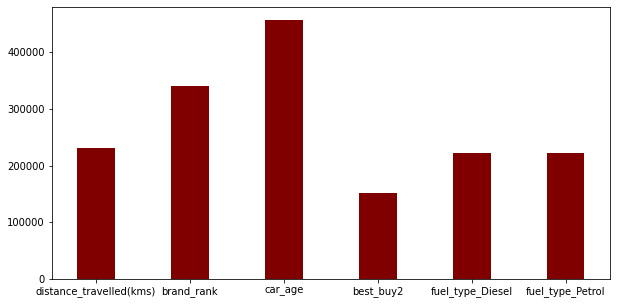

In [8]:
# PLotting the weights of the model in a barplot
import numpy as np
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dfr.columns[:-1] , abs(regressor.coef_), color ='maroon',
        width = 0.4)
plt.show()

#### As we can intuitively conclude, the car_age and brand_rank ( higher the rank, branded the car xd )  have the higher importance for the model.  
#### It is followed by the distance_travelled by the car and, actually, the type of fuel is not really an important choice for 2nd buyers. 

## Builing and plotting the Decision tree

In [9]:
from dtreeviz.trees import *

In [10]:
# Feature Engineering
dfc['gender'] = dfc['gender'].map({ 'M' : 0, 'F' :1})  
dfc['class'] = dfc['class'].map({'A':0, 'B':1, 'C' : 2,  'D' : 3  })  
# Eliminating by low correlation
dfc =dfc.drop(['age','height_cm', 'diastolic', 'gripForce','sit and bend forward_cm'], axis = 1)

In [11]:
# Splitting the data and training the model
X1 = dfc.iloc[:, :-1].values
y1 = dfc.iloc[:, -1].values 

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 0) 

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth=5) 
clf.fit(X_train1, y_train1)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [12]:
viz = dtreeviz(clf,
               x_data = X1,
               y_data = y1,
               target_name = 'class',
               feature_names = dfc.columns[:-1]
) 


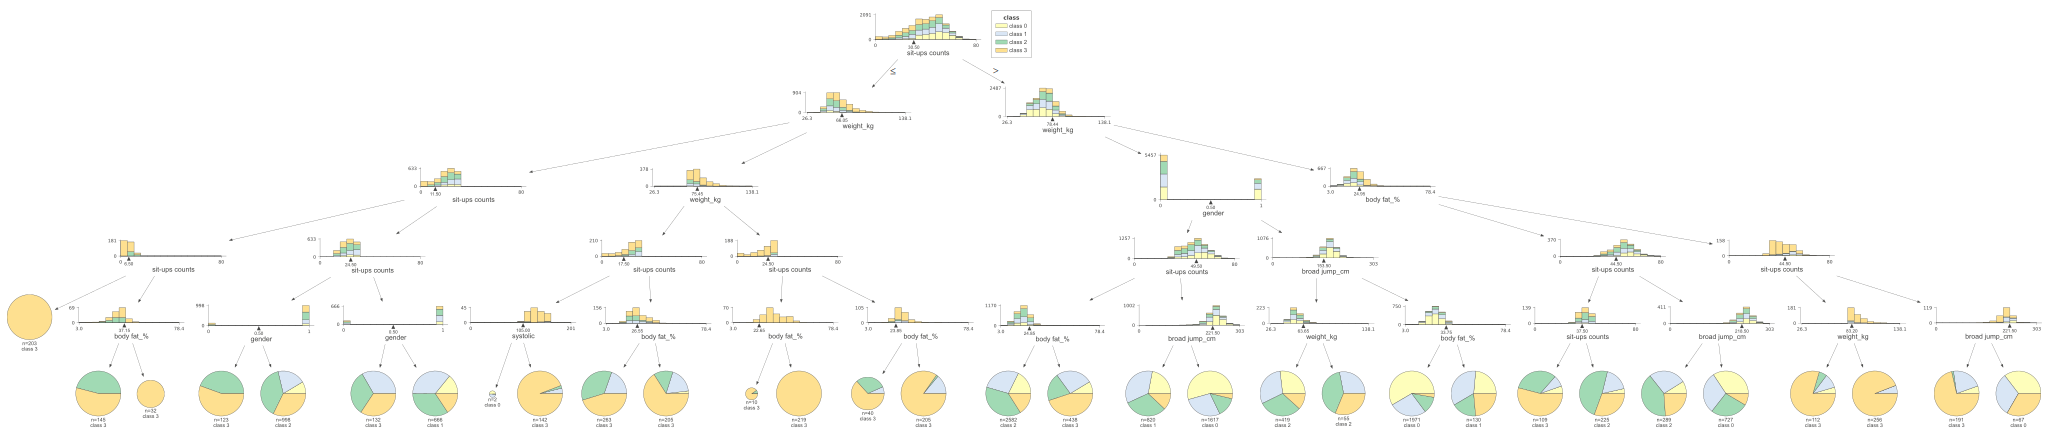

In [13]:
viz

### As we can observe, at this depth, the predominant features and sit-ups, weight, and body fat as they are the  higher leaves. 
### Since the classes are balanced, we can't make precise conclusion on the information split since they share a lot of information.

# Regression Table 

In [14]:
# Adding the regression models to the list
reg_list = list() 

from sklearn.neighbors import KNeighborsRegressor
reg_list.append(KNeighborsRegressor(n_neighbors=10))  

from sklearn.linear_model import LinearRegression
reg_list.append(LinearRegression()) 

from sklearn.ensemble import RandomForestRegressor
reg_list.append(RandomForestRegressor(n_estimators = 10, random_state = 0)) 

from sklearn.tree import DecisionTreeRegressor 
reg_list.append( DecisionTreeRegressor(random_state = 0)) 

In [15]:
# additional array for names
reg_list_name = ['KNNR', 'LR', 'RFR', 'DTR']

In [16]:
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [17]:
# Initializing an empty dataframe
df = pd.DataFrame(columns =['Estimator', 'MSE', 'MAE', 'RMSE'])

In [18]:
# Parsing and training the models. Also appending the results to the dataframe 
# Global pred array:
y_pred_ = 0
for i  in range(len(reg_list)):
    reg_list[i].fit(X_train,y_train) 
    y_pred = reg_list[i].predict(X_test) 
    # Saving the best model predcitions
    if i == 2:
        y_pred_ = y_pred
    new_row = {  'Estimator' : f'{reg_list_name[i]}', 
               'MSE' : f'{mean_squared_error(y_test, y_pred)}', 
               'MAE' : mean_absolute_error(y_test, y_pred),
               'RMSE' : mean_squared_error(y_test, y_pred)**1/2   } 
    df = df.append( new_row, ignore_index=True  )  

In [19]:
df

Estimator                 MSE            MAE          RMSE
0      KNNR  1269040791752.3364  593623.130841  6.345204e+11
1        LR   1999286234542.103  871642.693000  9.996431e+11
2       RFR   938741546862.0197  422206.113707  4.693708e+11
3       DTR  1589996469561.2668  422832.165109  7.949982e+11

# As we can observe, the most lower MSE and MAE belongs to Random Forest Regressor meaning it  has the most precise accuracy.

# Classifications models

In [20]:
# Initializing a list for classification models
cls_list = list()

from sklearn.linear_model import LogisticRegression
cls_list.append(LogisticRegression(random_state = 0, max_iter = 1000)) 

from sklearn.naive_bayes import GaussianNB
cls_list.append(GaussianNB()) 

from sklearn.neighbors import KNeighborsClassifier 
cls_list.append(KNeighborsClassifier(n_neighbors=3)) 

from sklearn.ensemble import RandomForestClassifier
cls_list.append(  RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) )


from sklearn.tree import DecisionTreeClassifier
cls_list.append(   DecisionTreeClassifier(criterion = 'entropy', random_state = 0)  ) 

from sklearn.naive_bayes import BernoulliNB
cls_list.append(BernoulliNB()) 

from sklearn.naive_bayes import MultinomialNB
cls_list.append( MultinomialNB() ) 




In [21]:
# additional list for the names
cls_list_name = [ 'LogReg', 'GausNB', 'KNCls', 'RFCls', 'DTCls', 'BernouliNB', 'MultinomialNB' ]

In [22]:
# Initializing an empty dataframe for classificator's evaluations
df2 = pd.DataFrame(columns =['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [23]:
# importing the metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score  
from sklearn.metrics import recall_score  
from sklearn.metrics import f1_score 

In [24]:
# Training and appending the model's scores to the dataframe

for i  in range(len(cls_list)):
    cls_list[i].fit(X_train1,y_train1) 
    y_pred = cls_list[i].predict(X_test1)

    
    new_row = {  'Estimator' : cls_list_name[i] ,  
               'Accuracy' : accuracy_score(y_test1,y_pred), 
               'Precision' :  precision_score(y_test1, y_pred, average= 'weighted') ,
               'Recall' : recall_score(y_test1, y_pred,  average= 'weighted'),   
               'F1-Score' : f1_score(y_test1, y_pred,  average= 'weighted')
              } 
    df2 = df2.append( new_row, ignore_index=True  )  

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
df2

Estimator  Accuracy  Precision    Recall  F1-Score
0         LogReg  0.493282   0.470161  0.493282  0.474056
1         GausNB  0.424306   0.391993  0.424306  0.394436
2          KNCls  0.424903   0.437530  0.424903  0.422082
3          RFCls  0.475664   0.475198  0.475664  0.473605
4          DTCls  0.419827   0.418502  0.419827  0.419093
5     BernouliNB  0.286354   0.397889  0.286354  0.200734
6  MultinomialNB  0.408182   0.373018  0.408182  0.375823

### The most precise are LogisticRegression and RandonForest  
### A better recall and actually score belongs to LogisticRegression 
### A almost the same Recall and Precision on RandomForest means the model is equally good at assigning positive classifications correctly as it is at classifying positive instances correctly. 
### The Precision and F1 score on LogReg are almost the same, meaning that the model is  good at precision of correct positive classifications as it is at classifying negative instances correctly, and less incorrect negative classificition. ( less FN). 

# SHAP BarPlot

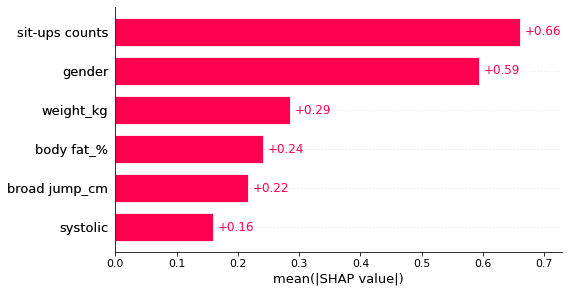

In [26]:
import shap
#  initializing JS driver for plots
shap.initjs()  
# Initializing the explainer
explainer = shap.Explainer( cls_list[0].predict, 
                           X_train1, 
                          feature_names = list(dfc.columns)[:-1])  
# Training set.
shap_values = explainer(X_test1)  
# Plotting
shap.plots.bar(shap_values, max_display = 14)

## Highest influence on prediction belongs to sit-ups counts and gender features.

# SHAP waterfall

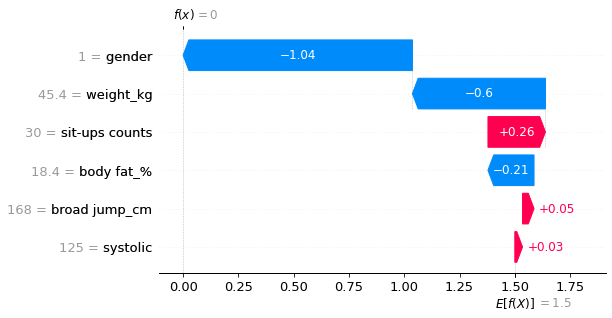

In [27]:
shap.plots.waterfall(shap_values[35])

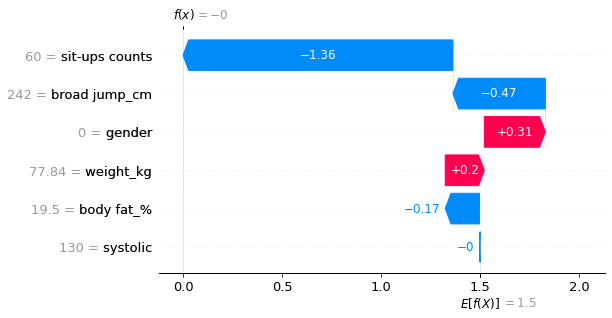

In [28]:
shap.plots.waterfall(shap_values[0])

### We can see that in the first plot the gender influences negative the expceted model/ predicted probability output but in the second plot it is positive ( Male and Female influence).  The inverse is for sit-ups counts.  
### Since the plots only show a single sample worth of data, we can’t see the impact of all the rows.

# SHAP BEESWARM

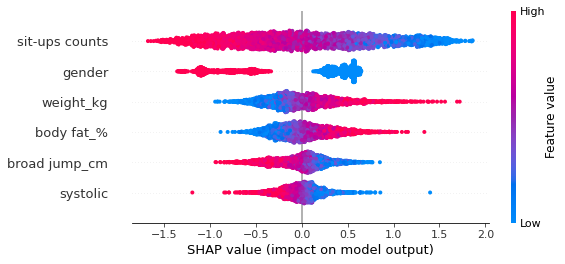

In [29]:
shap.plots.beeswarm(shap_values, max_display = 14)

#  Feature importance: Sit-ups counts is the most influencial/important feature.
#  Correlation: A high level of the “weight” and "body fat" have a high and postive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “systolic” and "borad jump_cm" are negatively correlated with the target variable.


# SHAP force plot

In [30]:
shap.force_plot(shap_values[5], X_test[5])

### For this piece of sample we have  that the body fat, broad jumps, and weight actually  have a higher influence on prediction, having a higher value than their mean. 

# LIME Intrepretation

In [31]:
import lime

In [32]:
# Initilizing the explained
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                  feature_names = list(dfr.iloc[:,:-1].columns), 
                                                  class_names = ['price'],
                                                   categorical_features =  ['fuel_type_Diesel', 'fuel_type_Petrol'],
                                                   verbose = True, 
                                                   mode = 'regression'
                                                  )

In [33]:
# Getting indexes of maximum deviation from correct values
max_ = dict()
for i in range(len(y_test)): 
    max_.update( {  abs( y_pred_[i] - y_test[i]) : i } )   
    
# Sorting the dict
import collections
od = collections.OrderedDict(sorted(max_.items(), reverse = True)) 

# Getting the indexes of max deviation of y^ and y. 
max_ = list()
for x in od.values():
    if len(max_) == 3:
        break
    max_.append(x)


In [34]:
for x in max_:
    exp  = explainer.explain_instance(X_test[x], reg_list[2].predict) 
    exp.show_in_notebook(show_table = True, show_all = False)

Intercept 1355542.2506948495
Prediction_local [3094975.9788926]
Right: 3490000.0


Intercept 1440760.907292474
Prediction_local [2493872.00227559]
Right: 8025000.0


Intercept 1788905.9126490292
Prediction_local [1398624.40993728]
Right: 5075000.0


# We could see that different features influence differently the prediction of the model.  
# Just some values from specific features influenced drastically the prediction. That means that small changes in the values, change the whole prediction process.  